# **Capstone Project - Weather Data Analysis and Forecasting for Different Regions in the Country**

---

### Problem Statement
#### 1. Collect weather data from [OpenWeatherMap API](https://openweathermap.org/) and [Weather API](https://www.weatherapi.com/) for different regions in Kenya
#### 2. Store it in a database of your choice (relational or non-relational)
#### 3. Analyze weather patterns using Python.

##### The goal is to derive insights into temperature trends, rainfall patterns, and other weather variables across different regions.

##### These insights can help users make informed decisions for weather-sensitive activities, such as agriculture, tourism, and outdoor events.

---

In [23]:

#? import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import json
import time
import requests
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [11]:

#? load environmental variables from a dotenv file
load_dotenv()
api_key=os.getenv('API_KEY') #? get API key
database_url=os.getenv('DATABASE_URL') #? get database URL
db_url=f'postgresql+psycopg2://{database_url}' #? format database connection string

#? load county data from JSON file and extract the city names
with open('data/counties.json','r') as f:
    counties=json.load(f)

#? list of cities for data collection
cities=[county['name'] for county in counties]

#? set unit for temperature in Celsius
unit='metric' 

base_url='https://api.openweathermap.org/data/2.5/weather' #? base URL for OpenWeatherMap API

def get_weather_openweathermap(city):
    url=f'{base_url}?q={city},KE&appid={api_key}&units={unit}'
    response=requests.get(url)

    if response.status_code==200:
        data=response.json()
        return data
    else:
        print(f'Failed to get data for {city}:{response.status_code}')
        return None

def collect_and_store_weather_data(cities):
    weather_data_list=[] #? list to store data for each city
    
    for city in cities:
        data=get_weather_openweathermap(city) #? fetch weather data for each city
        if data:
            #? extract relevant weather information
            weather_info={
                'city':data['name'],
                'country':data['sys']['country'],
                'latitude':data['coord']['lat'],
                'longitude':data['coord']['lon'],
                'temperature':data['main']['temp'],
                'humidity':data['main']['humidity'],
                'pressure':data['main']['pressure'],
                'wind_speed':data['wind']['speed'],
                'visibility':data['visibility'],
                'rain':data['rain']['1h'] if 'rain' in data and '1h' in data['rain'] else 0,
                'clouds':data['clouds']['all'],
                'sunrise':pd.to_datetime(data['sys']['sunrise'],unit='s',utc=True),
                'sunset':pd.to_datetime(data['sys']['sunset'],unit='s',utc=True),
                'weather_condition':data['weather'][0]['main'],
                'weather_description':data['weather'][0]['description'],
                'datetime':pd.to_datetime(data['dt'],unit='s',utc=True)
            }

            weather_data_list.append(weather_info) #? add weather information to the list

        time.sleep(1) #? wait for 1 second before fetching the next city(API rate limit)


    if weather_data_list:
        df=pd.DataFrame(weather_data_list) #? convert list to dataframe

        engine=create_engine(db_url) #? create database engine

        #? store weather data in the database
        df.to_sql('weather_data',engine,if_exists='append',index=False)
        print('Data stored successfully.')

        #? store weather data in a CSV file
        csv_file='weather_data.csv'
        if not os.path.exists(csv_file):
            #? write with headers if it's a new file
            df.to_csv(csv_file, mode='w', header=True, index=False)
        else:
             #? append without headers if file exists
             df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        print('No data to store.')

collect_and_store_weather_data(cities)

Failed to get data for Tana River:404
Failed to get data for Taita-Taveta:404
Failed to get data for Tharaka-Nithi:404
Failed to get data for Nyandarua:404
Failed to get data for Kirinyaga:404
Failed to get data for Turkana:404
Failed to get data for West Pokot:404
Failed to get data for Samburu:404
Failed to get data for Trans-Nzoia:404
Failed to get data for Uasin Gishu:404
Failed to get data for Elgeyo-Marakwet:404
Failed to get data for Laikipia:404
Failed to get data for Busia:404
Data stored successfully.


In [32]:
df=pd.read_csv('data/weather_data.csv',parse_dates=['datetime','sunrise','sunset'],date_format=pd.to_datetime)
df.shape

(34, 16)

In [19]:
df.head()

,city,country,latitude,longitude,temperature,humidity,pressure,wind_speed,visibility,rain,clouds,sunrise,sunset,weather_condition,weather_description,datetime
0,Mombasa,KE,-4.0547,39.6636,24.92,86,1016,5.91,10000,0.22,2,2024-10-11 03:02:28+00:00,2024-10-11 15:13:15+00:00,Rain,light rain,2024-10-11 17:00:37+00:00
1,Kwale,KE,-4.1738,39.4521,21.48,89,1016,3.69,10000,0.00,2,2024-10-11 03:03:16+00:00,2024-10-11 15:14:10+00:00,Clear,clear sky,2024-10-11 17:01:10+00:00
2,Kilifi,KE,-3.6305,39.8499,25.07,86,1015,6.49,10000,0.00,1,2024-10-11 03:01:57+00:00,2024-10-11 15:12:18+00:00,Clear,clear sky,2024-10-11 17:01:12+00:00
3,Lamu,KE,-2.2717,40.9020,25.29,87,1015,6.90,10000,0.00,8,2024-10-11 02:58:25+00:00,2024-10-11 15:07:24+00:00,Clear,clear sky,2024-10-11 17:01:18+00:00
4,Garissa,KE,-0.4536,39.6401,28.62,52,1012,12.09,10000,0.00,1,2024-10-11 03:04:23+00:00,2024-10-11 15:11:32+00:00,Clear,clear sky,2024-10-11 17:01:23+00:00


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   city                 34 non-null     object             
 1   country              34 non-null     object             
 2   latitude             34 non-null     float64            
 3   longitude            34 non-null     float64            
 4   temperature          34 non-null     float64            
 5   humidity             34 non-null     int64              
 6   pressure             34 non-null     int64              
 7   wind_speed           34 non-null     float64            
 8   visibility           34 non-null     int64              
 9   rain                 34 non-null     float64            
 10  clouds               34 non-null     int64              
 11  sunrise              34 non-null     datetime64[ns, UTC]
 12  sunset               34 

In [21]:
df.dtypes

city                                object
country                             object
latitude                           float64
longitude                          float64
temperature                        float64
humidity                             int64
pressure                             int64
wind_speed                         float64
visibility                           int64
rain                               float64
clouds                               int64
sunrise                datetime64[ns, UTC]
sunset                 datetime64[ns, UTC]
weather_condition                   object
weather_description                 object
datetime               datetime64[ns, UTC]
dtype: object

In [22]:
df['weather_condition'].value_counts()

weather_condition
Clouds    20
Rain       7
Clear      7
Name: count, dtype: int64

In [23]:
df['weather_condition'].unique()

array(['Rain', 'Clear', 'Clouds'], dtype=object)

In [24]:
df['weather_description'].value_counts()

weather_description
broken clouds       11
clear sky            7
light rain           5
few clouds           4
scattered clouds     3
overcast clouds      2
moderate rain        2
Name: count, dtype: int64

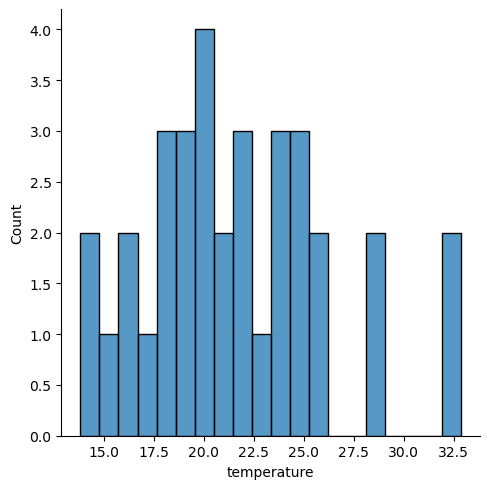

In [31]:
sns.displot(df['temperature'],bins=20)

In [28]:
df['temperature'].describe()

count    34.000000
mean     21.690294
std       4.621484
min      13.820000
25%      18.512500
50%      21.065000
75%      24.660000
max      32.870000
Name: temperature, dtype: float64

### load weather data into a DataFrame

In [129]:
df1=pd.read_csv('data/weatherData.csv')
df1.shape

(3000, 13)

### basic exploration of the data

In [5]:
df1.head()

,datetime,city,latitude,longitude,temperature_celsius,humidity_pct,pressure_hpa,wind_speed_ms,visibility,rain,clouds,weather_condition,weather_description
0,2023-12-22 22:38:40+03,Mandera,3.93564,41.85512,11.98,85,1019,18.41,8983,0.67,62,clear,thunderstorms with light rains
1,2024-01-26 03:42:03+03,Athi River,-1.45772,36.97850,35.63,40,1061,14.74,2572,0.46,95,clear,heavy snow
2,2023-12-01 15:01:00+03,Lodwar,3.11552,35.60408,31.27,93,938,8.06,13040,0.65,17,clear,partly cloudy
3,2023-11-29 11:47:55+03,Homa Bay,-0.53504,34.45310,27.12,52,1033,13.44,11360,0.46,32,drizzle,thunderstorms with light rains
4,2023-11-26 17:32:53+03,Kisii,-0.67733,34.77960,24.42,33,877,14.22,18295,0.80,85,clouds,hazy


In [6]:
df1.describe()

,latitude,longitude,temperature_celsius,humidity_pct,pressure_hpa,wind_speed_ms,visibility,rain,clouds
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.289563,36.451627,25.038303,49.739333,977.900333,9.898843,9973.426000,0.501743,49.576000
std,1.524973,1.860513,8.614879,29.097152,62.782771,5.839568,5707.286668,0.288120,29.040857
min,-4.139340,34.111460,10.000000,0.000000,870.000000,0.010000,5.000000,0.000000,0.000000
25%,-1.087540,34.779600,17.717500,24.000000,923.000000,4.720000,4989.750000,0.250000,24.000000
50%,-0.248840,36.364290,25.230000,50.000000,979.000000,9.840000,9941.000000,0.510000,50.000000
75%,0.490110,37.459640,32.502500,75.000000,1031.000000,15.090000,14865.250000,0.750000,75.000000
max,3.935640,41.855120,40.000000,100.000000,1085.000000,20.000000,20000.000000,1.000000,100.000000


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             3000 non-null   object 
 1   city                 3000 non-null   object 
 2   latitude             3000 non-null   float64
 3   longitude            3000 non-null   float64
 4   temperature_celsius  3000 non-null   float64
 5   humidity_pct         3000 non-null   int64  
 6   pressure_hpa         3000 non-null   int64  
 7   wind_speed_ms        3000 non-null   float64
 8   visibility           3000 non-null   int64  
 9   rain                 3000 non-null   float64
 10  clouds               3000 non-null   int64  
 11  weather_condition    3000 non-null   object 
 12  weather_description  3000 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 304.8+ KB


In [8]:

#? check for null values
df1.isnull().sum()

datetime               0
city                   0
latitude               0
longitude              0
temperature_celsius    0
humidity_pct           0
pressure_hpa           0
wind_speed_ms          0
visibility             0
rain                   0
clouds                 0
weather_condition      0
weather_description    0
dtype: int64

### Type conversion of the `datetime` column

In [9]:
df1['datetime']=pd.to_datetime(df1['datetime'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   datetime             3000 non-null   datetime64[ns, UTC+03:00]
 1   city                 3000 non-null   object                   
 2   latitude             3000 non-null   float64                  
 3   longitude            3000 non-null   float64                  
 4   temperature_celsius  3000 non-null   float64                  
 5   humidity_pct         3000 non-null   int64                    
 6   pressure_hpa         3000 non-null   int64                    
 7   wind_speed_ms        3000 non-null   float64                  
 8   visibility           3000 non-null   int64                    
 9   rain                 3000 non-null   float64                  
 10  clouds               3000 non-null   int64                    
 11  weat

In [10]:

#? Get descriptive statistics for numerical columns
print(df1[['temperature_celsius', 'humidity_pct', 'pressure_hpa', 'wind_speed_ms', 'rain', 'clouds']].describe())


       temperature_celsius  humidity_pct  pressure_hpa  wind_speed_ms  \
count          3000.000000   3000.000000   3000.000000    3000.000000   
mean             25.038303     49.739333    977.900333       9.898843   
std               8.614879     29.097152     62.782771       5.839568   
min              10.000000      0.000000    870.000000       0.010000   
25%              17.717500     24.000000    923.000000       4.720000   
50%              25.230000     50.000000    979.000000       9.840000   
75%              32.502500     75.000000   1031.000000      15.090000   
max              40.000000    100.000000   1085.000000      20.000000   

              rain       clouds  
count  3000.000000  3000.000000  
mean      0.501743    49.576000  
std       0.288120    29.040857  
min       0.000000     0.000000  
25%       0.250000    24.000000  
50%       0.510000    50.000000  
75%       0.750000    75.000000  
max       1.000000   100.000000  


### top cities with the most frequent weather recordings

In [11]:
df1['city'].value_counts().head(10)

city
Kakamega    94
Homa Bay    81
Kabarnet    80
Eldoret     79
Ol Kalou    76
Busia       71
Keruguya    70
Siaya       70
Bungoma     70
Kiambu      69
Name: count, dtype: int64

### weather condition analysis
#### distribution of different weather parameters

Text(0.5, 0, 'Temperature (Celsius)')

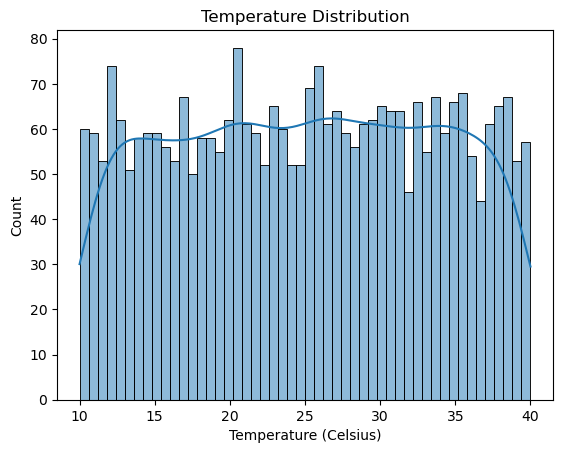

In [71]:
sns.histplot(df1['temperature_celsius'],bins=50,kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (Celsius)')

Text(0.5, 9.444444444444438, 'Rainfall (mm/h)')

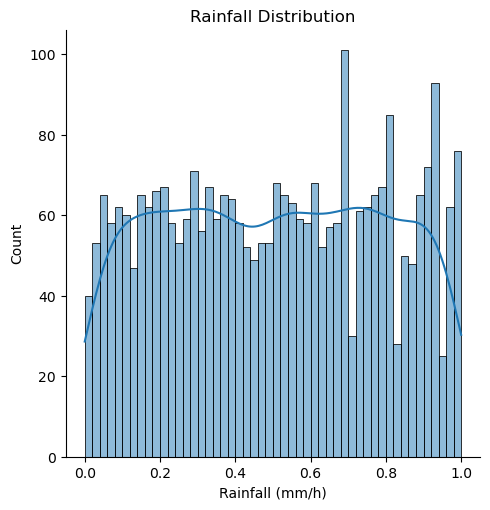

In [113]:
sns.displot(df1['rain'],bins=50,kde=True)
plt.title('Rainfall Distribution')
plt.xlabel('Rainfall (mm/h)')

Text(0.5, 9.444444444444438, 'Humidity (%)')

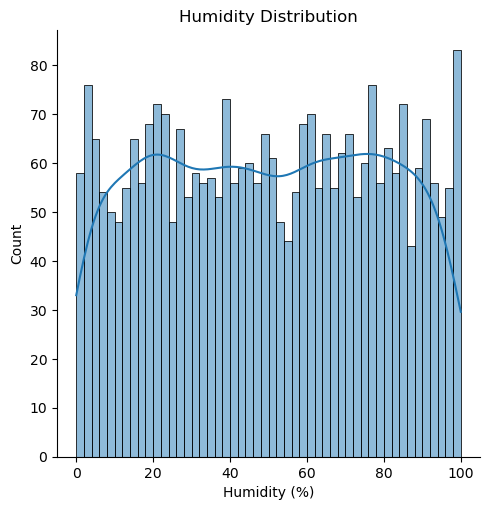

In [70]:
sns.displot(df1['humidity_pct'],bins=50,kde=True)
plt.title('Humidity Distribution')
plt.xlabel('Humidity (%)')

Text(0.5, 9.444444444444438, 'Pressure (hPa)')

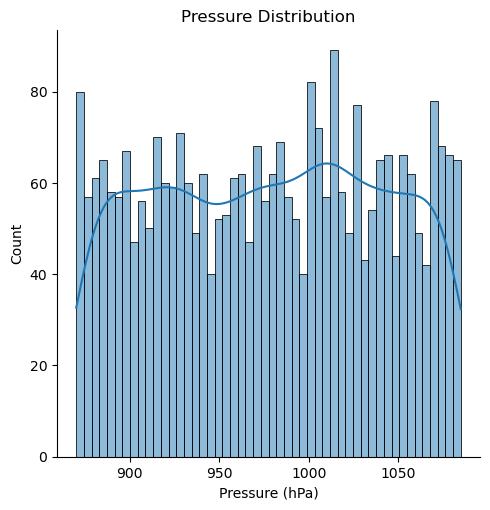

In [69]:
sns.displot(df1['pressure_hpa'],bins=50,kde=True)
plt.title('Pressure Distribution')
plt.xlabel('Pressure (hPa)')

Text(0.5, 9.444444444444438, 'Wind Speed (m/s)')

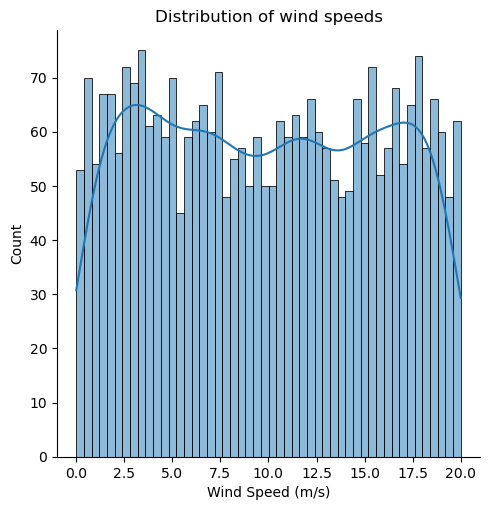

In [68]:
sns.displot(df1['wind_speed_ms'],bins=50,kde=True)
plt.title('Distribution of wind speeds')
plt.xlabel('Wind Speed (m/s)')

### proportional distribution of the different weather conditions

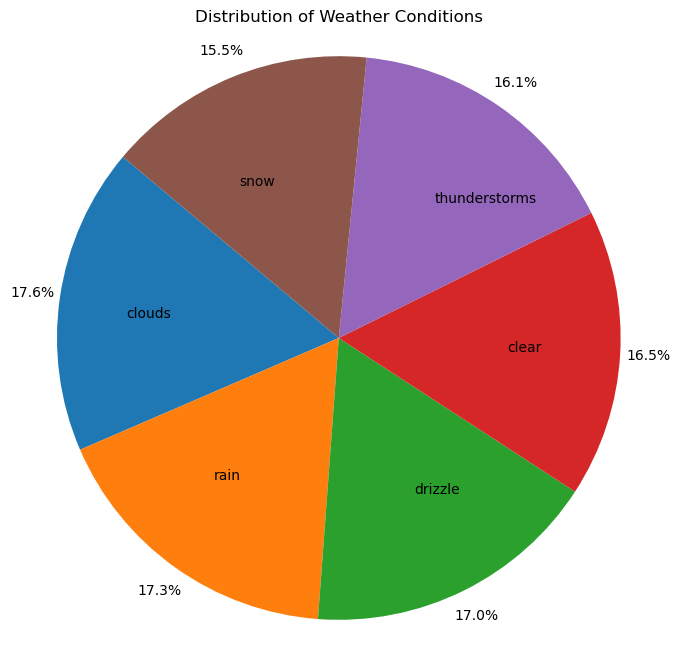

In [51]:
# Get the count of each weather condition
condition_counts = df1['weather_condition'].value_counts()

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(condition_counts, labels=condition_counts.index, autopct='%1.1f%%', pctdistance=1.1, labeldistance=0.6, startangle=140)
plt.title('Distribution of Weather Conditions')
plt.axis('equal')
plt.show()


### total amount of rain across different cities

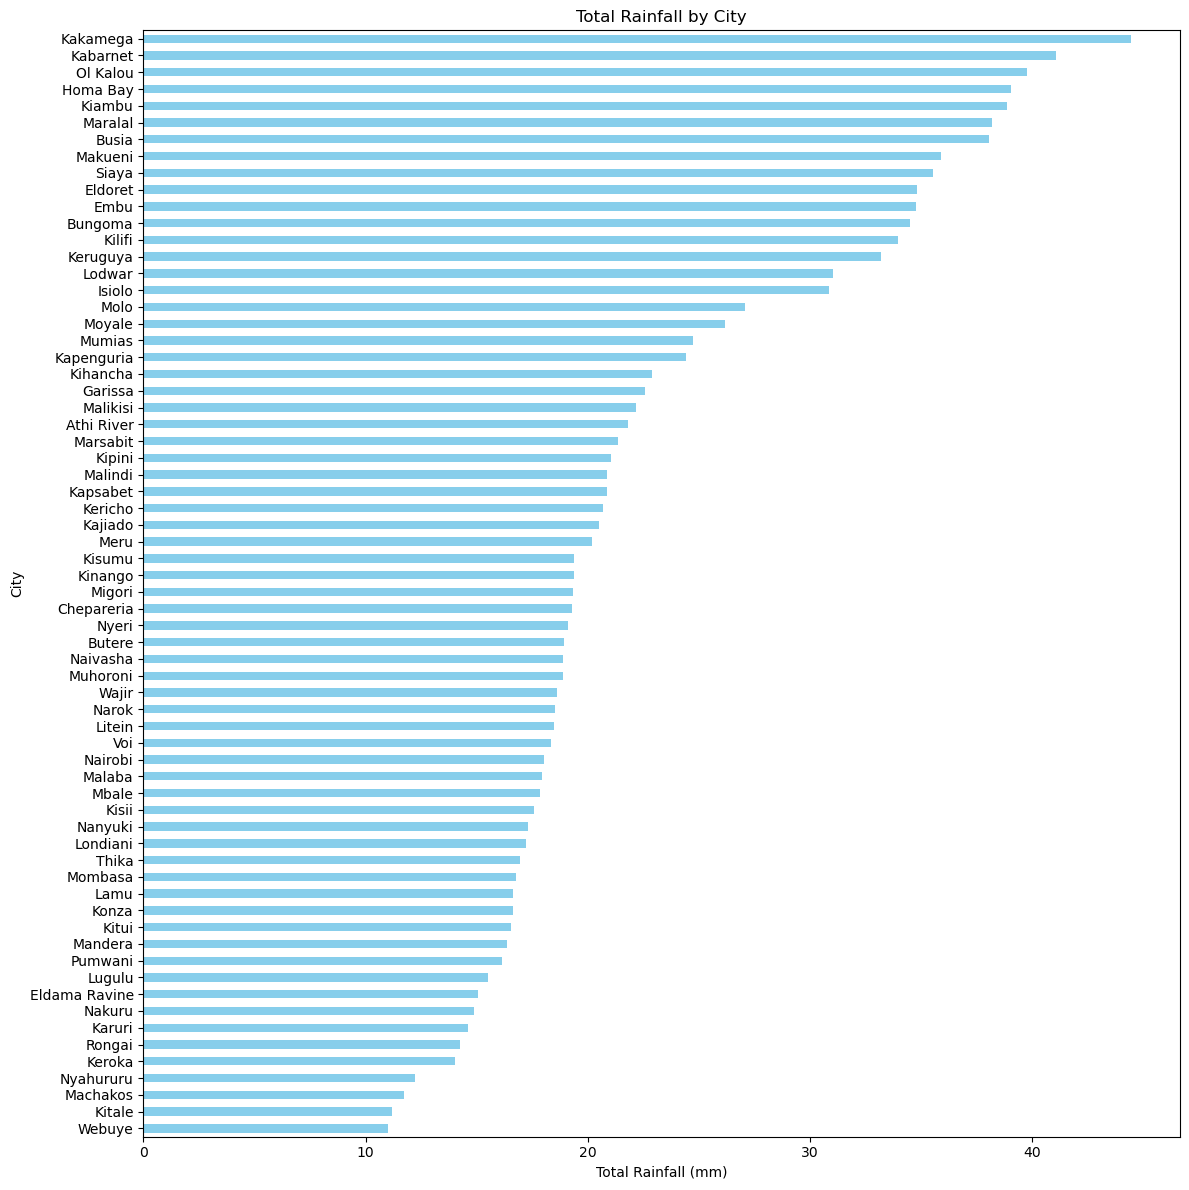

In [90]:

#? Total rainfall by city
rainfall_by_city = df1.groupby('city')['rain'].sum().sort_values()

#? Plot bar chart
plt.figure(figsize=(12,12))
rainfall_by_city.plot(kind='barh', color='skyblue')
plt.title('Total Rainfall by City')
plt.xlabel('Total Rainfall (mm)')
plt.ylabel('City')
plt.tight_layout()
plt.show()


### finding out how weather patterns over time

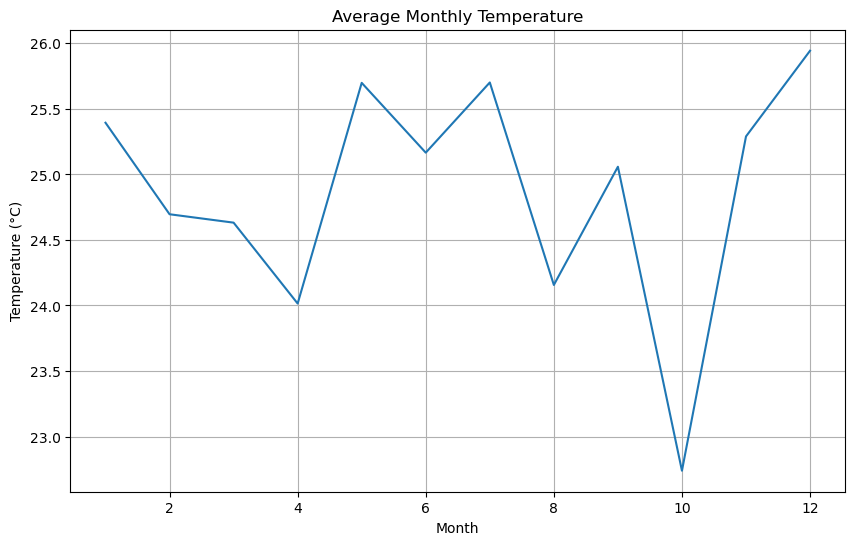

In [75]:

#? Extract month from datetime
df1['month'] = df1['datetime'].dt.month

#? Average temperature by month
avg_temp_by_month = df1.groupby('month')['temperature_celsius'].mean()

#? Plot temperature trend by month
plt.figure(figsize=(10,6))
avg_temp_by_month.plot(kind='line')
plt.title('Average Monthly Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


Text(0.5, -18.27777777777778, 'Month')

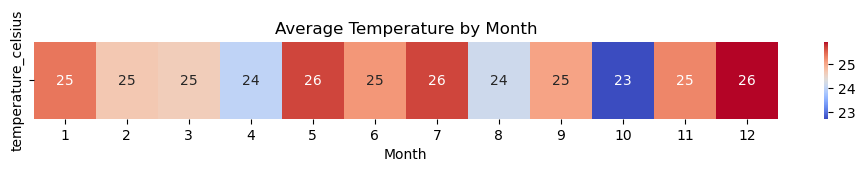

In [112]:
monthly_temp=df1[['month','temperature_celsius']].groupby('month').mean()
monthly_temp_df=monthly_temp.T
plt.figure(figsize=(12, 1))  # Adjust the height since we're only plotting one row
sns.heatmap(monthly_temp_df, annot=True, cmap="coolwarm", cbar=True)
plt.title('Average Temperature by Month')
plt.xlabel('Month')

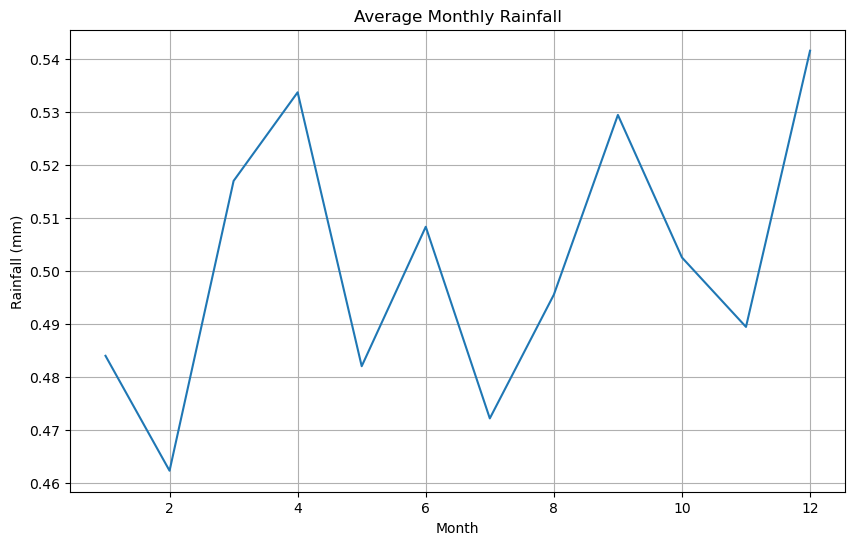

In [103]:
monthly_rain=df1.groupby('month')['rain'].mean()

# Plot rainfall trend by month
plt.figure(figsize=(10,6))
monthly_rain.plot(kind='line')
plt.title('Average Monthly Rainfall')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()

Text(0.5, -18.27777777777778, 'Month')

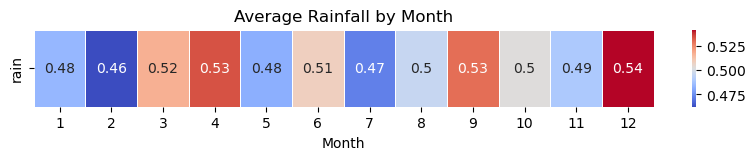

In [111]:
monthly_rain_df=monthly_rain.to_frame().T
plt.figure(figsize=(10,1))
sns.heatmap(monthly_rain_df,annot=True,cmap='coolwarm',cbar=True,linewidths=0.5)
plt.title('Average Rainfall by Month')
plt.xlabel('Month')

### finding out relationships between weather variables

In [107]:

#? Correlation matrix
correlation_matrix = df1[['temperature_celsius', 'humidity_pct', 'pressure_hpa', 'wind_speed_ms', 'rain', 'clouds']].corr()
correlation_matrix

,temperature_celsius,humidity_pct,pressure_hpa,wind_speed_ms,rain,clouds
temperature_celsius,1.000000,0.017061,-0.048710,0.002178,-0.022256,0.010126
humidity_pct,0.017061,1.000000,0.003718,-0.007870,-0.021714,-0.008798
pressure_hpa,-0.048710,0.003718,1.000000,0.018021,-0.003573,-0.000697
wind_speed_ms,0.002178,-0.007870,0.018021,1.000000,-0.013044,-0.005088
rain,-0.022256,-0.021714,-0.003573,-0.013044,1.000000,-0.005708
clouds,0.010126,-0.008798,-0.000697,-0.005088,-0.005708,1.000000


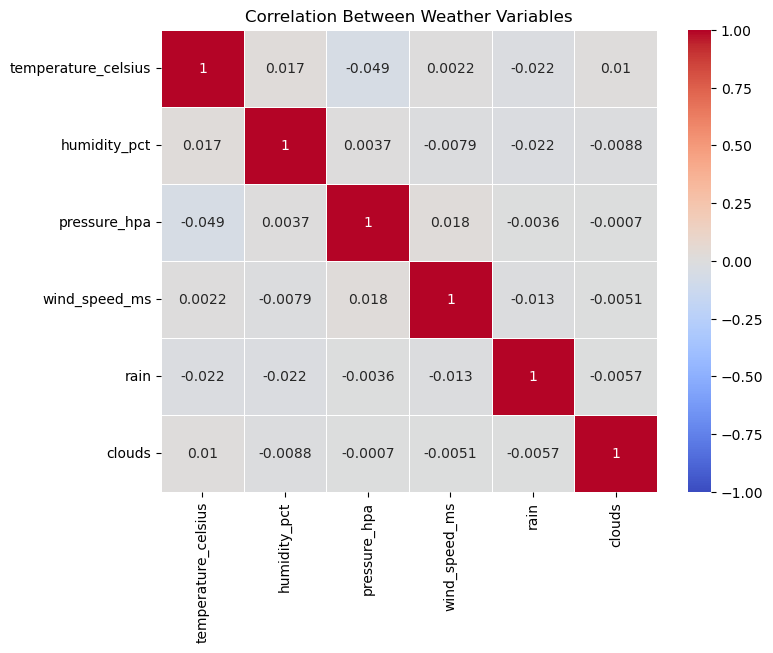

In [110]:

#? Heatmap for better visualization
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',vmin=-1,vmax=1,linewidths=0.5)
plt.title('Correlation Between Weather Variables')
plt.show()

#### general conclusion
Very Weak or No Correlation - The correlation matrix shows that none of the weather variables have a strong linear relationship with each other in your dataset. Most correlations are extremely close to zero, indicating independence or a very weak relationship between the variables.

### visualizing key weather trends by cities
#### line charts to visualise trends over  time for a particular city

### temperature trends for Mombasa

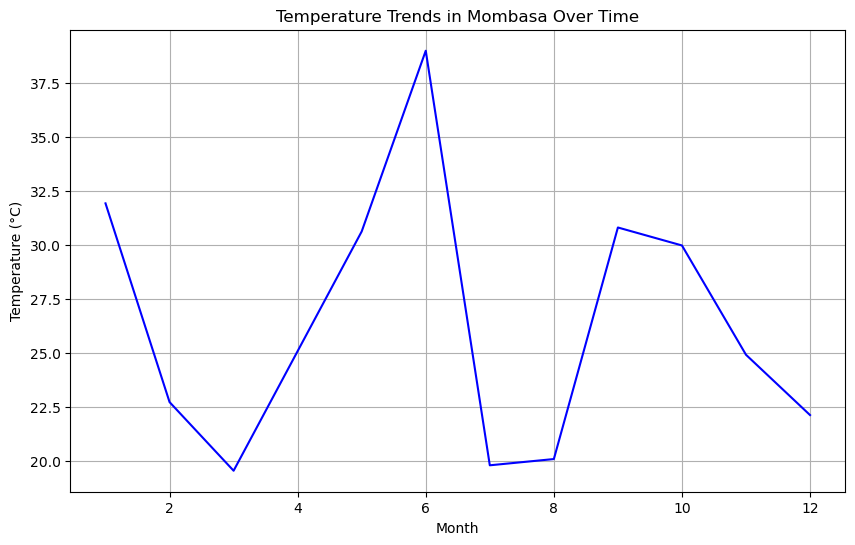

In [119]:
mombasa_df = df1[df1['city'] == 'Mombasa']

monthly_avg_temp_msa=mombasa_df[['month','temperature_celsius']].groupby('month').mean()
plt.figure(figsize=(10,6))
plt.plot(monthly_avg_temp_msa, label='Mombasa', color='blue')
plt.title('Temperature Trends in Mombasa Over Time')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


In [120]:
mombasa_df.head()

,datetime,city,latitude,longitude,temperature_celsius,humidity_pct,pressure_hpa,wind_speed_ms,visibility,rain,clouds,weather_condition,weather_description,month
285,2024-01-21 10:53:49+03:00,Mombasa,-4.04348,39.66821,39.19,63,1063,14.41,10278,0.60,71,clouds,moderate rain,1
286,2023-11-05 14:32:05+03:00,Mombasa,-4.04348,39.66821,29.75,3,995,17.70,12619,0.74,67,drizzle,cloudy,11
355,2023-11-17 21:17:09+03:00,Mombasa,-4.04348,39.66821,20.74,4,897,7.62,10152,0.83,44,thunderstorms,moderate rain,11
435,2023-11-29 20:28:48+03:00,Mombasa,-4.04348,39.66821,26.28,78,970,12.82,16496,0.05,63,drizzle,thunderstorms,11
444,2023-11-01 19:06:28+03:00,Mombasa,-4.04348,39.66821,11.91,16,1081,13.80,3139,0.18,73,drizzle,foggy,11


In [121]:
mombasa_df.shape

(37, 14)

### rainfall trends for Nyeri

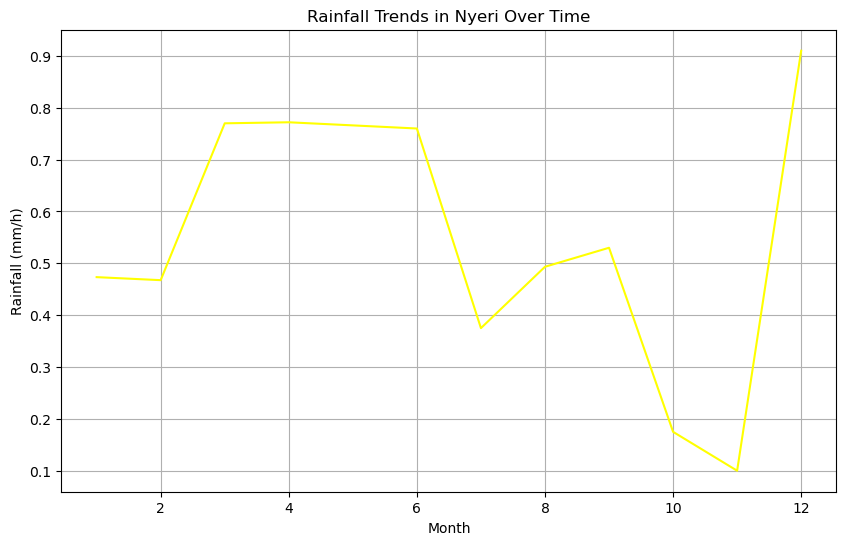

In [125]:
nyeri_df = df1[df1['city'] == 'Nyeri']

monthly_avg_rain_nyr=nyeri_df[['month','rain']].groupby('month').mean()
plt.figure(figsize=(10,6))
plt.plot(monthly_avg_rain_nyr, label='Nyeri', color='yellow')
plt.title('Rainfall Trends in Nyeri Over Time')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm/h)')
plt.grid(True)
plt.show()

In [126]:
nyeri_df.head()

,datetime,city,latitude,longitude,temperature_celsius,humidity_pct,pressure_hpa,wind_speed_ms,visibility,rain,clouds,weather_condition,weather_description,month
98,2024-01-13 08:31:15+03:00,Nyeri,-0.42778,36.94336,16.64,72,893,4.37,1988,0.06,34,rain,heavy snow,1
163,2023-11-10 07:17:37+03:00,Nyeri,-0.42778,36.94336,29.64,0,1009,18.59,3016,0.10,17,drizzle,snowy,11
187,2024-01-27 17:00:11+03:00,Nyeri,-0.42778,36.94336,38.75,38,891,9.59,8210,0.41,100,drizzle,thunderstorms,1
549,2024-01-30 23:01:27+03:00,Nyeri,-0.42778,36.94336,30.40,52,1047,3.62,3048,0.72,78,clouds,thunderstorms,1
575,2023-12-05 07:49:33+03:00,Nyeri,-0.42778,36.94336,18.56,70,1028,5.93,4476,0.91,34,thunderstorms,moderate rain,12


---